# Лабораторная работа №3 “Переобучение и регуляризация”


In [16]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## 1. Загрузите данные ex3data1.mat из файла.

In [17]:
from scipy.io import loadmat

mat = loadmat('data/ex3data1.mat')
mat_y = mat['y']
x_train, y_train = mat['X'], mat_y.reshape(len(mat_y))

yval = mat['yval']
x_val, y_val = mat['Xval'], yval.reshape(len(yval))

ytest = mat['ytest']
x_test, y_test = mat['Xtest'], ytest.reshape(len(ytest))

## 2. Постройте график, где по осям откладываются X и y из обучающей выборки.

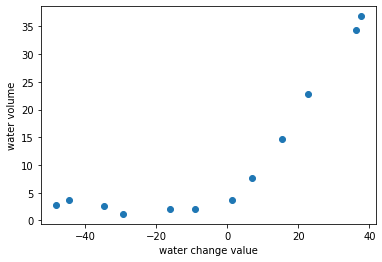

In [19]:
plt.plot(x_train, y_train, 'o')
plt.xlabel('water change value')
plt.ylabel('water volume')
plt.show()

## 3. Реализуйте функцию стоимости потерь для линейной регрессии с L2-регуляризацией.

In [222]:
def h(x, theta):
    if len(x.shape) > 1 and x.shape[1] < theta.shape[0]:
        x = np.column_stack((np.ones(x.shape[0]), x))

    return x.dot(theta)

def cost_func(x, y, theta, l2_penalty_value=0.1):
    err = (h(x, theta) - y) ** 2

    theta_ = theta[1:]
    total_cost = err.sum() + l2_penalty_value * np.dot(theta_.T, theta_)
    return total_cost / 2 / x.shape[0]

## 4. Реализуйте функцию градиентного спуска для линейной регрессии с L2-регуляризацией.


In [223]:
THRESHOLD = 1e-7

def gradient_descent(x, y, max_iters_count=300000, a=0.001, l2_penalty_value=0.1, cost_func=cost_func):
    theta = np.zeros(x.shape[1])
    last_loss = cost_func(x, y, theta)
    logs = []

    for i in range(max_iters_count):
        diff = h(x, theta) - y
        gradient_first = np.dot(x.T[:1], diff)
        gradient_full = np.dot(x.T[1:], diff) + l2_penalty_value * theta[1:]
        gradient = np.insert(gradient_full, 0, gradient_first)
        gradient /= x.shape[0]
        gradient *= a
        theta -= gradient 

        curr_los = cost_func(x, y, theta)
        logs.append(curr_los)
        if abs(curr_los - last_loss) < THRESHOLD:
            break

        last_loss = curr_los

    return theta, logs

## 5. Постройте модель линейной регрессии с коэффициентом регуляризации 0 и постройте график полученной функции совместно с графиком из пункта 2. Почему регуляризация в данном случае не сработает?


In [224]:
def normalize_features(x):
    N = x.shape[1]
    copy_x = x.copy()
    for i in range(N):
        feature = x[:, i]
        mean = np.mean(feature)
        delta = np.max(feature) - np.min(feature)            
        copy_x[:, i] -= mean
        copy_x[:, i] /= delta
    return copy_x

In [225]:
def fit(x, y, normalize=False, **kwargs):
    x = x.astype('float64') 
    y = y.astype('float64')

    if normalize:
        x = normalize_features(X)

    x = np.column_stack((np.ones(x.shape[0]), x))

    return gradient_descent(x, y, **kwargs)

In [226]:
def predict(x, theta):
    x_extended = np.insert(x, 0, 1)        
    return h(x_extended, theta)

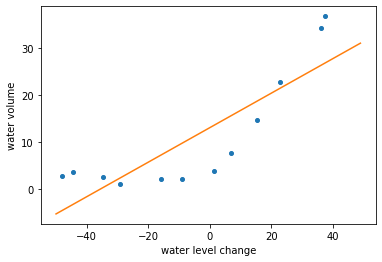

In [227]:
theta, logs = fit(x_train, y_train, a=0.001, max_iters_count=1000000, l2_penalty_value=0)

xi = list(range(-50, 50))
line = [predict(np.array(i), theta) for i in xi]
plt.plot(x_train, y_train, 'o', xi, line, markersize=4)
plt.xlabel('water level change')
plt.ylabel('water volume')
plt.show()

Во первых, когда коэффициент регуляризации равен 0, то мы получаем обычную линейную регрессию.
Во вторых, из графика видно, что обычной прямой здесь будет недостаточно, таким образом, нужны дополнительные переменные и фукция зависимости должна быть нелинейной.

## 6. Постройте график процесса обучения (learning curves) для обучающей и валидационной выборки. По оси абсцисс откладывается число элементов из обучающей выборки, а по оси ординат - ошибка (значение функции потерь) для обучающей выборки (первая кривая) и валидационной выборки (вторая кривая). Какой вывод можно сделать по построенному графику?


In [261]:
# https://www.dataquest.io/blog/learning-curves-machine-learning/

def learning_curves(cost_func, x_train, y_train, x_val, y_val, max_axis=100, l2_penalty_value=0, **kwargs):
    N = len(y_train)
    train_err = np.zeros(N)
    val_err = np.zeros(N)

    for i in range(1, N):
        theta, logs = fit(x_train[0:i + 1, :], y_train[0:i + 1], l2_penalty_value=l2_penalty_value, **kwargs)
        train_err[i] = cost_func(x_train[0:i + 1, :], y_train[0:i + 1], theta, l2_penalty_value=l2_penalty_value)
        val_err[i] = cost_func(x_val, y_val, theta, l2_penalty_value=l2_penalty_value)

    plt.plot(range(2, N + 1), train_err[1:], c="r", linewidth=2)
    plt.plot(range(2, N + 1), val_err[1:], linewidth=2)
    plt.xlabel("number of training examples")
    plt.ylabel("error")
    plt.legend(["training", "validation"], loc="best")
    plt.axis([2, N, 0, max_axis])
    plt.show()

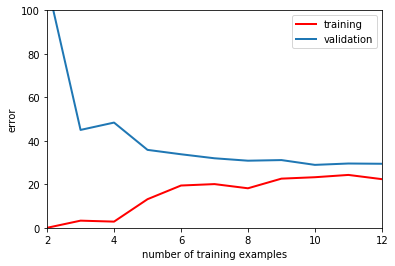

In [262]:
learning_curves(cost_func, x_train, y_train, X_val, y_val)

Исходя из графика можно сделать вывод, что модель недообучена. Так как даже на обучающей выборке у нас большая ошибка.

## 7. Реализуйте функцию добавления p - 1 новых признаков в обучающую выборку (X2, X3, X4, …, Xp).

In [256]:
def make_polynom_of_features(x, degree):
    x = x.reshape(x.shape[0])
    x_res = np.array(x)

    for i in range(2, degree + 1):
        x_res = np.column_stack((x_res, x ** i))

    return x_res

## 8. Поскольку в данной задаче будет использован полином высокой степени, то необходимо перед обучением произвести нормализацию признаков.
Функция normalize_features выше.

## 9. Обучите модель с коэффициентом регуляризации 0 и p = 8.

In [264]:
x_train_poly = normalize_features(make_polynom_of_features(x_train, 8))
theta, _ = fit(x_train_poly, y_train, a=0.3, max_iters_count=500000, l2_penalty_value=0)

## 10. Постройте график модели, совмещенный с обучающей выборкой, а также график процесса обучения. Какой вывод можно сделать в данном случае?

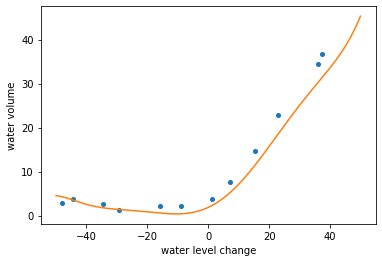

In [265]:
def draw_model(theta):
    xi = np.linspace(-50, 50, 1000)
    x_extended = normalize_features(make_polynom_of_features(xi, 8))
    line = [predict(i, theta) for i in x_extended]
    plt.plot(x_train, y_train, 'o', xi, line, markersize=4)
    plt.xlabel('water level change')
    plt.ylabel('water volume')
    plt.show()
    
draw_model(theta)

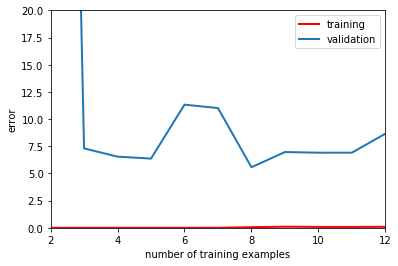

In [267]:
x_val_extended = normalize_features(make_polynom_of_features(x_val, 8))
learning_curves(cost_func, x_train_poly, y_train, x_val_extended, y_val,
                max_axis=20, l2_penalty_value=0, max_iters_count=500000, a=0.3)

Исходя из графика можно сделать вывод, что модель переобучена. Так как на обучающей выборке у нас ошибка очень маленькая,
а на валидационной ошибка не стремится к 0.

## 11. Постройте графики из пункта 10 для моделей с коэффициентами регуляризации 1 и 100. Какие выводы можно сделать?


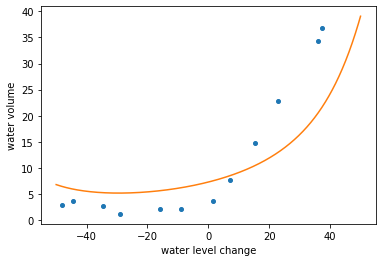

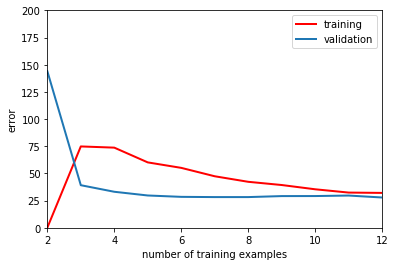

In [276]:
x_val_extended = normalize_features(make_polynom_of_features(x_val, 8))

theta, _ = fit(x_train_poly, y_train, a=1, max_iters_count=500000, l2_penalty_value=1)
def draw_model(theta):
    xi = np.linspace(-50, 50, 1000)
    x_extended = normalize_features(make_polynom_of_features(xi, 8))
    line = [predict(i, theta) for i in x_extended]
    plt.plot(x_train, y_train, 'o', xi, line, markersize=4)
    plt.xlabel('water change value')
    plt.ylabel('water volume')
    plt.show()

draw_model(theta)

learning_curves(cost_func, x_train_poly, y_train, x_val_extended, y_val,
                max_axis=200, l2_penalty_value=1, max_iters_count=500000, a=1)

Из графика процесса обучения можно сделать вывод, что модель достаточно хорошо обучается.
Также сам график для модели выглядит более сглаженным. Однако, ошибка все еще велика.

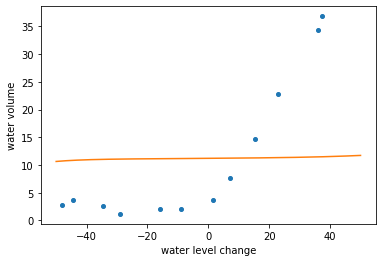

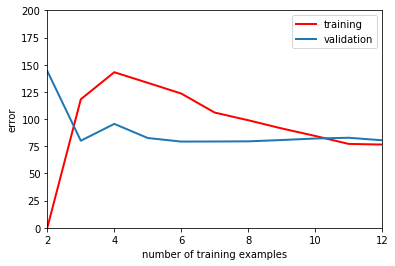

In [278]:
theta, _ = fit(x_train_poly, y_train, a=0.01, max_iters_count=500000, l2_penalty_value=100)
def draw_model(theta):
    xi = np.linspace(-50, 50, 1000)
    x_extended = normalize_features(make_polynom_of_features(xi, 8))
    line = [predict(i, theta) for i in x_extended]
    plt.plot(x_train, y_train, 'o', xi, line, markersize=4)
    plt.xlabel('water level change')
    plt.ylabel('water volume')
    plt.show()

draw_model(theta)

x_val_extended = normalize_features(make_polynom_of_features(x_val, 8))
learning_curves(cost_func, x_train_poly, y_train, x_val_extended, y_val,
                max_axis=200, l2_penalty_value=100, max_iters_count=500000, a=0.01)

График для модели - почти прямая. Наша L2 регуляризация делает коэфициенты theta очень маленькими при x. Таким образом, мы получаем функцию, значения которой приблизительно равны theta0.

## 12. С помощью валидационной выборки подберите коэффиент регуляризации, который позволяет достичь наименьшей ошибки. Процесс подбора отразите с помощью графика (графиков).

0.05

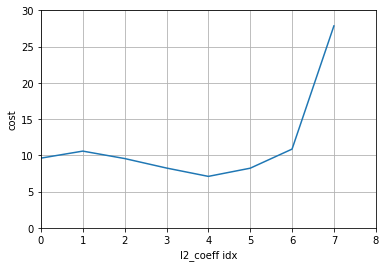

In [288]:
l2_coeff_choices = [0, 0.003, 0.005, 0.01, 0.05, 0.1, 0.2, 1]
costs = []

for l2_choice in l2_coeff_choices:
    theta, _ = fit(x_train_poly, y_train, l2_penalty_value=l2_choice, a=0.4)
    costs.append(cost_func(x_val_extended, y_val, theta, l2_penalty_value=l2_choice))

min_err_idx = np.argmin(np .array(costs))
best_l2_coeff = l2_coeff_choices[min_err_idx]

plt.plot(list(range(0, 8)), costs)
plt.axis([0, 8, 0, 30])
plt.xlabel('l2_coeff idx')
plt.ylabel('cost')
plt.grid()
best_l2_coeff

## 13. Вычислите ошибку (потерю) на контрольной выборке.

In [291]:
theta, _ = fit(x_train_poly, y_train, l2_penalty_value=0.05, a=0.4)
x_test_extended = normalize_features(make_polynom_of_features(x_test, 8))
err = cost_func(x_test_extended, y_test, theta, l2_penalty_value=0.05)
err

13.456730005306243